In [2]:
import os
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset
import imageio.v3 as iio
import numpy as np
import matplotlib.pyplot as plt
import time
from pthflops import count_ops
from tqdm import tqdm
import math

print(torch.__version__)

torch.manual_seed(42)

2.0.1


In [3]:
#Load video file
vRead = iio.imread('data/c_elegans.mp4')
video = np.array(vRead)
testFrame = video[0]

In [4]:
print("Cuda available: ", torch.cuda.is_available())
if(torch.cuda.is_available()):
    torch.cuda.set_device("cuda:1")

    print("Is cuDNN version:", torch.backends.cudnn.version())

    print("cuDNN enabled:a", torch.backends.cudnn.enabled)

    print("Device count: ", torch.cuda.device_count())

    print("Current device: ", torch.cuda.current_device())

    print("Device name: ", torch.cuda.get_device_name(torch.cuda.current_device()))
#Setup device agnostic code (i.e use GPU if possible)
device = "cuda" if torch.cuda.is_available() else "cpu"
gpuNum = 1
print(device)

Cuda available:  True
Is cuDNN version: 8700
cuDNN enabled:a True
Device count:  4
Current device:  1
Device name:  NVIDIA TITAN Xp
cuda


In [4]:
#Video Metadata
import imageio.v3 as iio
props = iio.improps("data/c_elegans.mp4")
print("Shape (frames, w, h, RGB): \n" + str(props.shape))
numFrames = props.shape[0]
print(props.dtype)

Shape (frames, w, h, RGB): 
(2484, 322, 344, 3)
uint8


In [5]:
if(os.path.isfile('testFrame.png') == False):
    frame1 = iio.imwrite('testFrame.png', testFrame,format='PNG')
else:
    print("test frame is already stored locally")

test frame is already stored locally


(512, 512, 3)


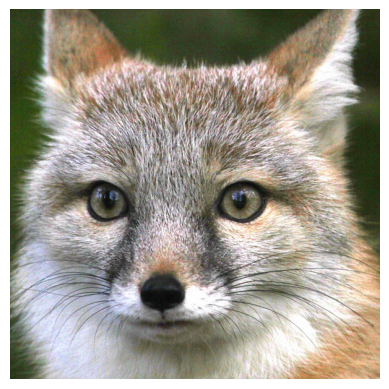

In [6]:
#process fox picture ONLY
image_url = 'https://live.staticflickr.com/7492/15677707699_d9d67acf9d_b.jpg'
imgFox = iio.imread(image_url)[..., :3] / 255
c = [imgFox.shape[0]//2, imgFox.shape[1]//2]
r = 256
imgFox = imgFox[c[0]-r:c[0]+r, c[1]-r:c[1]+r]

plt.imshow(imgFox)
plt.axis('off')
print(imgFox.shape)
img = imgFox
coords = np.linspace(0, 1, 512, endpoint=False)
x_test = np.stack(np.meshgrid(coords, coords), -1)
test_data = [x_test, img]


/tmp/ipykernel_1170760/3033158715.py:4: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525551200/work/torch/csrc/utils/tensor_numpy.cpp:199.)
  frame = torch.as_tensor(iio.imread('testFrame.png'))[:l, :l]


tensor([[[0.0157, 0.0157, 0.0157],
         [0.0667, 0.0667, 0.0667],
         [0.0902, 0.0902, 0.0902],
         ...,
         [0.0039, 0.0000, 0.0000],
         [0.0039, 0.0000, 0.0000],
         [0.0039, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000],
         [0.0392, 0.0392, 0.0392],
         [0.0588, 0.0588, 0.0588],
         ...,
         [0.0039, 0.0000, 0.0000],
         [0.0039, 0.0000, 0.0000],
         [0.0039, 0.0000, 0.0000]],

        [[0.0706, 0.0706, 0.0706],
         [0.1020, 0.1020, 0.1020],
         [0.0863, 0.0863, 0.0863],
         ...,
         [0.0039, 0.0000, 0.0000],
         [0.0039, 0.0000, 0.0000],
         [0.0039, 0.0000, 0.0000]],

        ...,

        [[0.0157, 0.0157, 0.0157],
         [0.0392, 0.0392, 0.0392],
         [0.0196, 0.0196, 0.0196],
         ...,
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000],
         [0.0667, 0.0667, 0.0667],
         [0.

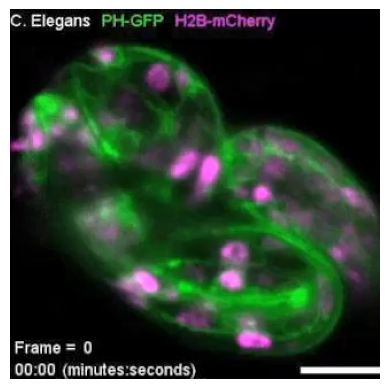

In [5]:
#FOR LOCAL IMAGE ONLY
#Square the image
l = min(2*(props.shape[1]//2), 2*(props.shape[2]//2))
#Encode Tensor
frame = torch.as_tensor(iio.imread('testFrame.png'))[:l, :l]

preImg = torch.as_tensor(frame).to(device)
img = torch.mul(preImg, 1/255.0).type(torch.float64)
print(img)
plt.imshow(img.cpu())
plt.axis('off')
print('img is now on', img.device)
print(img.shape)

#generate coordinates in unit square
coords = np.linspace(0, 1, l, endpoint=False)
x_test = np.stack(np.meshgrid(coords, coords), -1)
test_data = [x_test, img]
print('shape of test data: ', x_test.shape)

In [7]:
def input_mapping(x, B):
    #print("shape of x:", x.shape)
    #print("shape of B:", B.shape)
    if B is None:
        return x
    else:
        B_T = np.array(B).T
        #print("B_T", B_T.shape)
        x_proj = torch.as_tensor(np.dot(2.0*(np.pi)* x, B_T))
        #print("x_proj:", x_proj, x_proj.shape)
        return np.concatenate([np.sin(x_proj), np.cos(x_proj)], axis=-1)   
#basic_mapping(np.array([1,1]), np.eye(2))

In [8]:
gen = torch.Generator()
gen.manual_seed(42)
gauss_mat = torch.normal(0.0, 1, size=(256, 2), generator=gen)

In [9]:
seed = 42
mapping_size = 256
mappings = {}
mappings['raw'] = None
mappings['identity'] = np.eye(2)
# ex: [1, 10, 100]
mappings['gaussian_fourier'] = lambda scale: scale * gauss_mat
print(mappings['gaussian_fourier'](25).shape)

torch.Size([256, 2])


In [10]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms

class MLP(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(input_shape, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units), 
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units), 
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units), 
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.Sigmoid(),
            nn.Linear(hidden_units, output_shape),
        )
    def forward(self, X):
        return self.layer_stack(X.to(device).type(torch.float32))


In [11]:
#INPUT SIZE IS 4 FOR BASIC AN NO-ENCODING
#I HAVE TO FIX THE GAUSSIAN ONES BECAUSE THEY ARE WACK WITH Huge matrix sizes
model_0 = MLP(input_shape=512, 
              hidden_units=256,
              output_shape=3).to(device)


In [12]:

lr1 = 0.0001
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=lr1)

In [19]:
### Save Model State Dictionary
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "pos_encoding_gauss_25_fox.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
MODEL_SAVE_PATH

#3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)
print(MODEL_SAVE_PATH)

Saving model to: models/pos_encoding_gauss_25_fox.pth
models/pos_encoding_gauss_25_fox.pth


In [13]:
##LOAD MODEL
# To load in a saved state_dict we have to instantiate a new instance of our model class
#loaded_model_0 = MLP() # new instance!

#Load the saved state_dict of model_0 (this wil updated the new instance with the updated parameters.)
model_0.load_state_dict(torch.load(f='models/pos_encoding_gauss_25_fox.pth'))

<All keys matched successfully>

In [11]:
#dataLoader
from torch.utils.data import DataLoader

class SingleImageDataset(Dataset):
    def __init__(self, data, mapping, transform=None, target_transform=None):
        self.train_data = data[0]
        self.img = data[1]
        self.B = mapping
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return img.shape[0] * img.shape[1]
    def __getitem__(self, idx):
        row = idx // int(img.shape[1])
        col = idx % int(img.shape[1])
        coords = torch.as_tensor(self.train_data[row][col]).type(torch.float64)
        pixel = torch.as_tensor(self.img[row][col]).type(torch.float64)
        return torch.as_tensor(input_mapping(coords, self.B)).type(torch.float64).cpu(), pixel.cpu()
training_data = SingleImageDataset(test_data, mappings['gaussian_fourier'](100))

In [12]:
#No mapping/encoding
from tqdm import tqdm

train_loader = DataLoader(training_data, batch_size=512, shuffle=True, pin_memory=True)

for epoch in tqdm(range(0,50)):
    #Training
    model_0.train()
    for batch in iter(train_loader):
        #print(batch[0].shape)
        encodings = torch.as_tensor(batch[0]).to(device)
        y_train = torch.as_tensor(batch[1]).to(device)
        y_train = torch.squeeze(y_train)
        X = torch.as_tensor(encodings).type(torch.float64).to(device)
        y_train = torch.as_tensor(y_train).type(torch.float64).to(device)
        # Forward Pass
        y_pred = model_0(X).to(device).type(torch.float64)
        loss = loss_fn(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 1 == 0:
        print(f"Epoch: {epoch} | LR: {lr1} | Train loss: {loss}")

print('Training finished')


  0%|          | 0/50 [00:13<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
def basic_encoding_reconstruction():
    model_0.eval()
    x_test_T = torch.as_tensor(x_test)
    reconstruction_input_matrix = torch.zeros(x_test_T.shape[0], x_test_T.shape[1], 4)
    #encode coordinates into debug matrix
    for i in range(0, x_test_T.shape[0]):
        for j in range(0, x_test_T.shape[1]):
            reconstruction_input_matrix[i][j] = torch.as_tensor(input_mapping(x_test_T[i][j], np.eye(2)))

    with torch.inference_mode():
        reconstruction = model_0(reconstruction_input_matrix).cpu()
        plt.imshow(reconstruction)
        plt.axis(False)
        plt.title("Basic Encoding")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


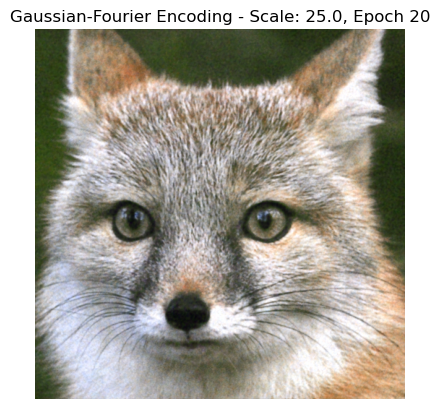

In [18]:
#Gaussian-Fourier Encoding tester
model_0.eval()
x_test_T = torch.as_tensor(x_test)
reconstruction_input_matrix = torch.zeros(x_test_T.shape[0], x_test_T.shape[1], 512)
#encode coordinates into debug matrix
for i in range(0, x_test_T.shape[0]):
    for j in range(0, x_test_T.shape[1]):
        reconstruction_input_matrix[i][j] = torch.as_tensor(input_mapping(x_test_T[i][j], mappings["gaussian_fourier"](25))).type(torch.float64)

with torch.inference_mode():
    reconstruction = model_0(reconstruction_input_matrix).cpu()
    plt.imshow(reconstruction)
    plt.axis(False)
    plt.title("Gaussian-Fourier Encoding - Scale: 25.0, Epoch 20")


Parameter containing:
tensor([[ 0.0161,  0.0275, -0.0255,  ..., -0.0282,  0.0014, -0.0685],
        [ 0.0061, -0.0242, -0.0520,  ..., -0.0313, -0.0439, -0.0154],
        [ 0.0169, -0.0083,  0.0073,  ..., -0.0047,  0.0254, -0.0446],
        ...,
        [ 0.0153,  0.0053,  0.0043,  ..., -0.0054, -0.0796, -0.0207],
        [-0.0163,  0.0383, -0.0037,  ...,  0.0220,  0.0193, -0.0718],
        [-0.0237,  0.0146, -0.0346,  ...,  0.0084, -0.0101, -0.0324]],
       device='cuda:1', requires_grad=True)
Parameter containing:
tensor([[ 0.0424, -0.0708,  0.0127,  ...,  0.0429, -0.0422, -0.0419],
        [-0.0323,  0.0381,  0.0321,  ...,  0.0227,  0.0272, -0.0061],
        [-0.0047, -0.0357,  0.0084,  ..., -0.0160,  0.0255, -0.0231],
        ...,
        [-0.0673, -0.0237, -0.0242,  ..., -0.0431,  0.0158,  0.0204],
        [ 0.0523,  0.0224,  0.0602,  ...,  0.0304,  0.0389,  0.0063],
        [ 0.0487,  0.0585,  0.0331,  ..., -0.0117,  0.0695,  0.0134]],
       device='cuda:1', requires_grad=True)


TypeError: Invalid shape (512, 3, 512) for image data

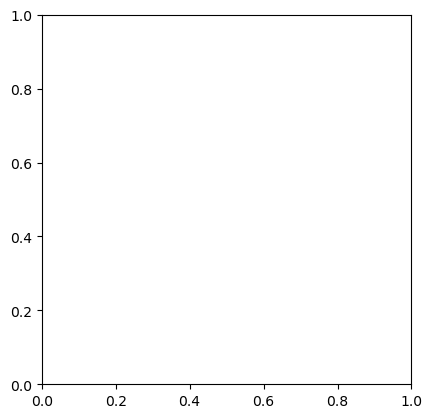

In [39]:
# Signal Processing Feature Extraction/data
# access wi
model_0.eval()
with torch.inference_mode():
    for i in range(0,4):
        print(model_0.layer_stack[2*i].weight)
    first_layer = torch.as_tensor(model_0.layer_stack[0].weight).cpu()
    second_layer = torch.as_tensor(model_0.layer_stack[10].weight).cpu()
    print(reconstruction_input_matrix.shape)
    print(first_layer.shape)
    print(second_layer.shape)
    first_feature_layer = torch.matmul(first_layer, reconstruction_input_matrix.cpu())
    first_feature_layer = torch.sigmoid(first_feature_layer)
    second_feature_layer = torch.matmul(second_layer, first_feature_layer)
    plt.imshow(second_feature_layer.numpy())


In [5]:
quit()

: 

In [9]:
# Check model size by summing parameters and state_dict
params_size = 0
for param in model_0.parameters():
    params_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model_0.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (params_size + buffer_size) / 1024**2
imageSize = 8 * img.shape[0] * img.shape[1] * img.shape[2]
imageSizeMB = imageSize / (10**6)
perDecrease = (imageSizeMB - size_all_mb) / imageSizeMB
perDecrease *= 100
print('original image size(no compression): {:.3f}MB'.format(imageSizeMB))
print('model size: {:.3f}MB'.format(size_all_mb))
print('Percent decrease in memory size: {:.3f}%'.format(perDecrease))

original image size(no compression): 6.291MB
model size: 1.508MB
Percent decrease in memory size: 76.034%
